In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
file_path = '../results/results_mini_nsga.csv'
nsga_data = pd.read_csv(file_path)

# Filtering out rows where latency or energy is infinity
nsga_data = nsga_data[(nsga_data['latency'] != float('inf')) & (nsga_data['energy'] != float('inf'))]

# Filter for generation 200 and alpha = 0.5 and beta = 0.5
nsga_data = nsga_data[(nsga_data['generations'] == 200) & (nsga_data['alpha'] == 0.5)].copy()

In [3]:
file_path = '../results/results_mini_bf.csv'
bf_data = pd.read_csv(file_path)

# Filtering out rows where latency or energy is infinity
bf_data = bf_data[(bf_data['latency'] != float('inf')) & (bf_data['energy'] != float('inf'))]

In [4]:
file_path = '../results/results_mini_ann.csv'
ann_data = pd.read_csv(file_path)

# Filtering out rows where latency or energy is infinity
ann_data = ann_data[(ann_data['latency'] != float('inf')) & (ann_data['energy'] != float('inf'))]

In [5]:
# Merging the three dataframes on the 'config' column
combined_data = pd.merge(nsga_data[['config', 'services', 'latency', 'energy', 'is_perfect']],
                         bf_data[['config', 'services', 'latency', 'energy', 'is_perfect']],
                         on=['config'], suffixes=('', '_bf'))
combined_data = pd.merge(combined_data, ann_data[['config', 'services', 'latency', 'energy', 'is_perfect']],
                         on=['config'], suffixes=('', '_ann'))

combined_data['obj_function'] = combined_data['latency'] * 0.5 + combined_data['energy'] * 0.5
combined_data['obj_function_bf'] = combined_data['latency_bf'] * 0.5 + combined_data['energy_bf'] * 0.5
combined_data['obj_function_ann'] = combined_data['latency_ann'] * 0.5 + combined_data['energy_ann'] * 0.5

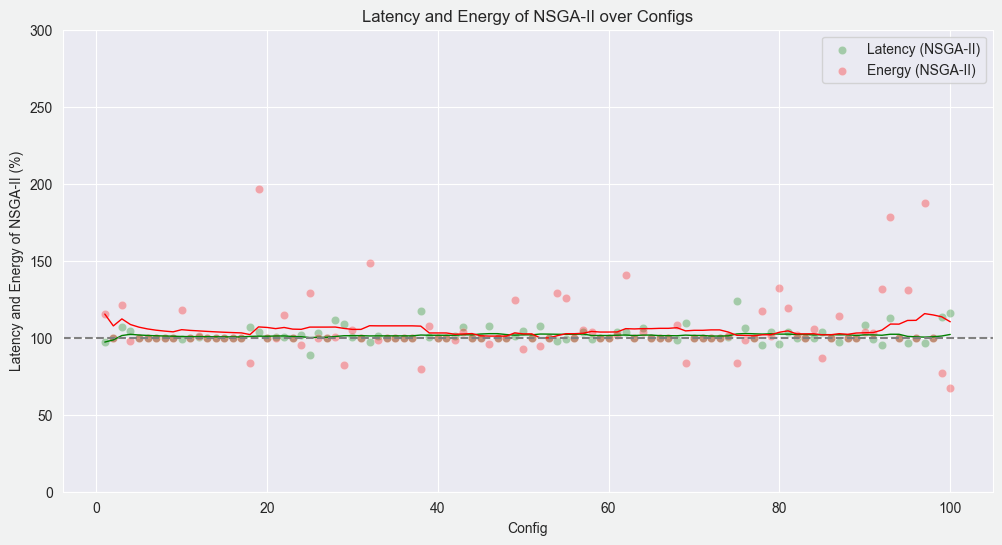

In [32]:
# Calculating latency and energy as a percentage of latency
combined_data['latency_nsga_percent'] = (combined_data['latency'] / combined_data['latency_bf']) * 100
combined_data['energy_nsga_percent'] = (combined_data['energy'] / combined_data['energy_bf']) * 100

# Extracting config number from the 'config' column
combined_data['config_number'] = combined_data['config'].str.extract('(\d+)').astype(int)

# Creating the line plot
plt.figure(figsize=(12, 6), facecolor='#f1f2f2')
sns.scatterplot(x='config_number', y='latency_nsga_percent', data=combined_data, label='Latency (NSGA-II)', color='green', alpha=0.3)
sns.scatterplot(x='config_number', y='energy_nsga_percent', data=combined_data, label='Energy (NSGA-II)', color='red', alpha=0.3)

# Drawing a moving average line through the scatter points
window_size = 20
sns.lineplot(x='config_number', y=combined_data['latency_nsga_percent'].rolling(window=window_size, min_periods=1).mean(), data=combined_data, color='green', lw=1)
sns.lineplot(x='config_number', y=combined_data['energy_nsga_percent'].rolling(window=window_size, min_periods=1).mean(), data=combined_data, color='red', lw=1)

plt.axhline(100, color='gray', linestyle='--')

plt.ylim(0, 300)
title = 'Latency and Energy of NSGA-II over Configs'
plt.title(title)
plt.xlabel('Config')
plt.ylabel('Latency and Energy of NSGA-II (%)')
plt.ylim(ymin=0)
plt.legend()
plt.savefig(f'../images/{title.replace(" ", "_")}')
plt.show()

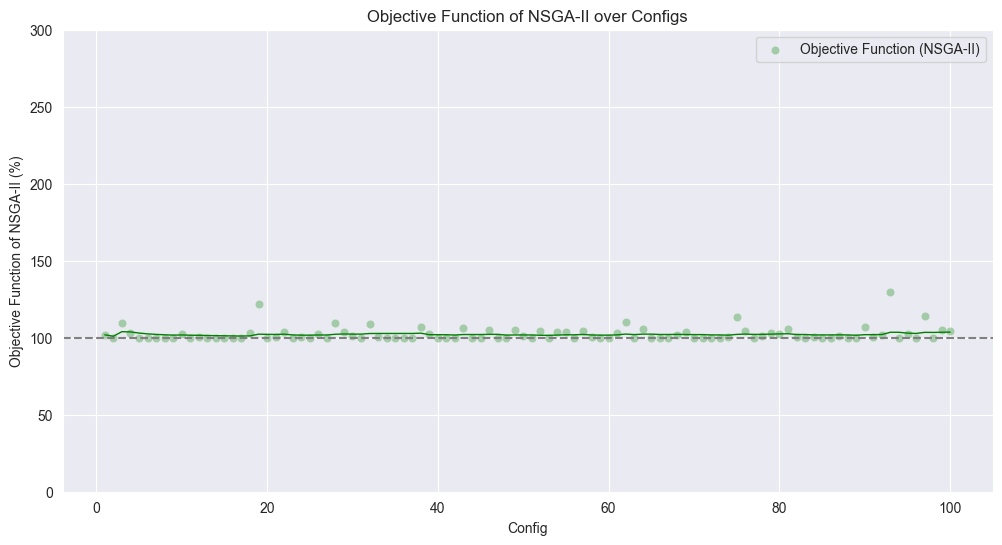

In [33]:
# Calculating objective fundtion as a percentage of brute force objective function
combined_data['obj_function_percentage'] = (combined_data['obj_function'] / combined_data['obj_function_bf']) * 100

# Creating the line plot
plt.figure(figsize=(12, 6), facecolor='#f1f2f2')
sns.scatterplot(x='config_number', y='obj_function_percentage', data=combined_data, label='Objective Function (NSGA-II)', color='green', alpha=0.3)

# Drawing a moving average line through the scatter points
window_size = 20
sns.lineplot(x='config_number', y=combined_data['obj_function_percentage'].rolling(window=window_size, min_periods=1).mean(), data=combined_data, color='green', lw=1)

plt.axhline(100, color='gray', linestyle='--')

plt.ylim(0, 300)
title = 'Objective Function of NSGA-II over Configs'
plt.title(title)
plt.xlabel('Config')
plt.ylabel('Objective Function of NSGA-II (%)')
plt.ylim(ymin=0)
plt.legend()
plt.savefig(f'../images/{title.replace(" ", "_")}')
plt.show()

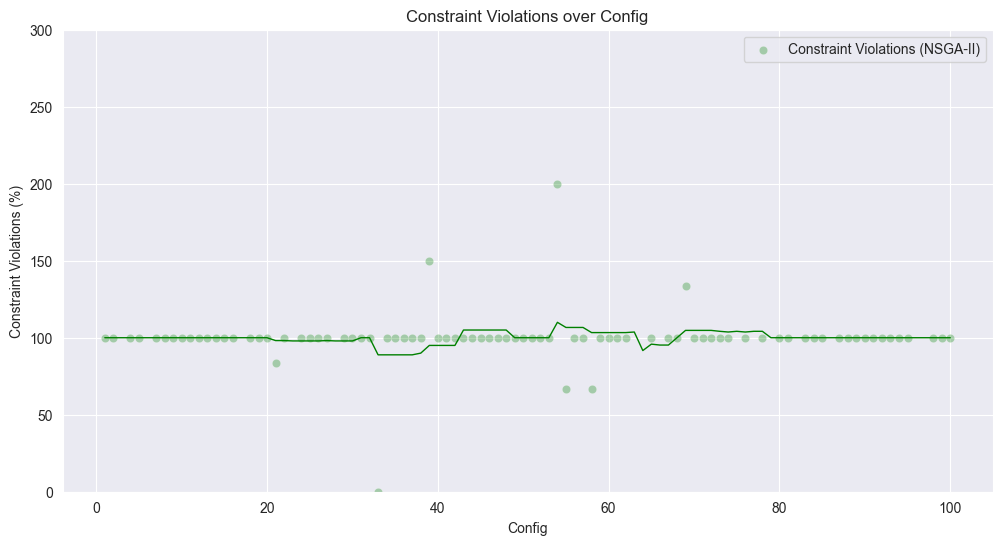

In [9]:
import ast

# Counting the number of False in is_perfect column for each config
combined_data['constraint_violations_nsga'] = combined_data['is_perfect'].apply(lambda x: ast.literal_eval(x).count(False))
combined_data['constraint_violations_bf'] = combined_data['is_perfect_bf'].apply(lambda x: ast.literal_eval(x).count(False))

# Calculating constraint_violations/services
combined_data['constraint_violations_nsga'] = combined_data['constraint_violations_nsga'] / combined_data['services']
combined_data['constraint_violations_bf'] = combined_data['constraint_violations_bf'] / combined_data['services']

combined_data['constraint_violations_nsga_percent'] = (combined_data['constraint_violations_nsga'] / combined_data['constraint_violations_bf']) * 100

# Creating the line plot
plt.figure(figsize=(12, 6))
sns.scatterplot(x='config_number', y='constraint_violations_nsga_percent', data=combined_data, label='Constraint Violations (NSGA-II)', color='green', alpha=0.3)

# Drawing a moving average line through the scatter points
window_size = 10
sns.lineplot(x='config_number', y=combined_data['constraint_violations_nsga_percent'].rolling(window=window_size, min_periods=1).mean(), data=combined_data, color='green', lw=1)

plt.ylim(0, 300)
title = 'Constraint Violations over Config'
plt.title(title)
plt.xlabel('Config')
plt.ylabel('Constraint Violations (%)')
plt.ylim(ymin=0)
plt.savefig(f'../images/{title.replace(" ", "_")}')
plt.show()

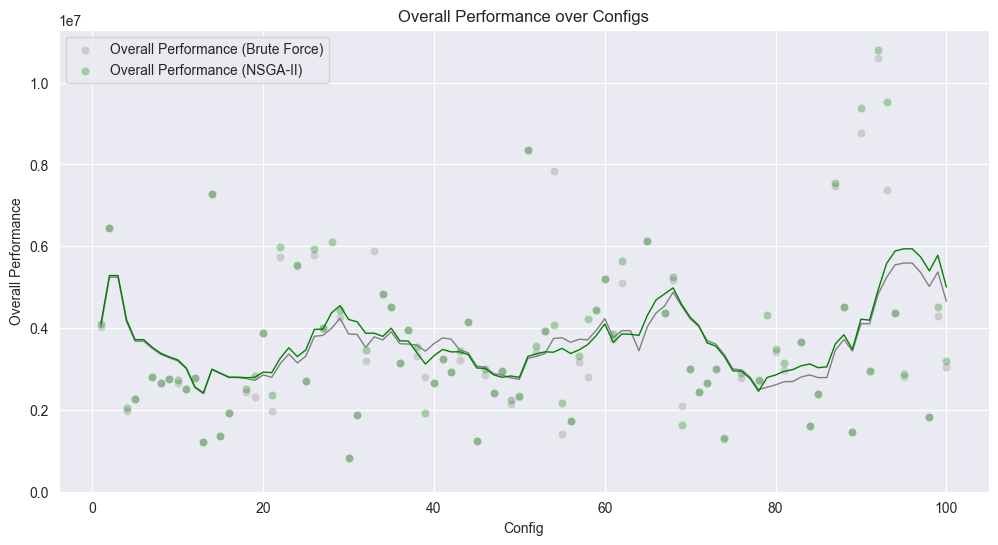

In [11]:
# Objective function * constraint_violations should give an idea of how much the objective function is affected by constraint violations
combined_data['obj_rate_bf'] = 100 / combined_data['constraint_violations_bf'] * combined_data['obj_function_bf']
combined_data['obj_rate_nsga'] = 100 / combined_data['constraint_violations_nsga'] * combined_data['obj_function']

# Creating the line plot
plt.figure(figsize=(12, 6))
sns.scatterplot(x='config_number', y='obj_rate_bf', data=combined_data, label='Overall Performance (Brute Force)', color='gray', alpha=0.3)
sns.scatterplot(x='config_number', y='obj_rate_nsga', data=combined_data, label='Overall Performance (NSGA-II)', color='green', alpha=0.3)

# Drawing a moving average line through the scatter points
window_size = 10
sns.lineplot(x='config_number', y=combined_data['obj_rate_bf'].rolling(window=window_size, min_periods=1).mean(), data=combined_data, color='gray', lw=1)
sns.lineplot(x='config_number', y=combined_data['obj_rate_nsga'].rolling(window=window_size, min_periods=1).mean(), data=combined_data, color='green', lw=1)

title = 'Overall Performance over Configs'
plt.title(title)
plt.xlabel('Config')
plt.ylabel('Overall Performance')
plt.ylim(ymin=0)
plt.savefig(f'../images/{title.replace(" ", "_")}')
plt.show()

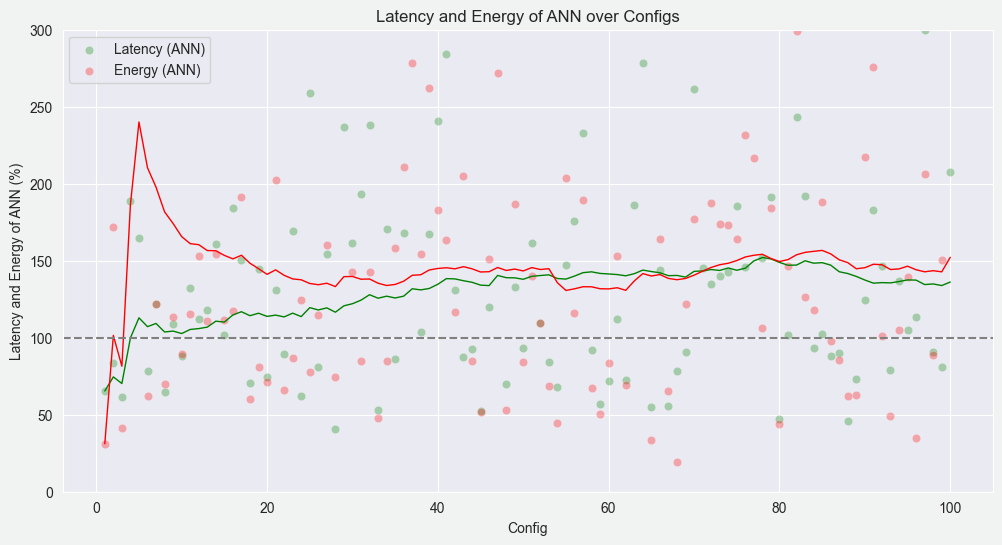

In [35]:
# Calculating latency and energy as a percentage of latency
combined_data['latency_ann_percent'] = (combined_data['latency_ann'] / combined_data['latency']) * 100
combined_data['energy_ann_percent'] = (combined_data['energy_ann'] / combined_data['energy']) * 100

# Extracting config number from the 'config' column
combined_data['config_number'] = combined_data['config'].str.extract('(\d+)').astype(int)

# Creating the line plot
plt.figure(figsize=(12, 6), facecolor='#f1f2f2')
sns.scatterplot(x='config_number', y='latency_ann_percent', data=combined_data, label='Latency (ANN)', color='green', alpha=0.3)
sns.scatterplot(x='config_number', y='energy_ann_percent', data=combined_data, label='Energy (ANN)', color='red', alpha=0.3)

# Drawing a moving average line through the scatter points
window_size = 50
sns.lineplot(x='config_number', y=combined_data['latency_ann_percent'].rolling(window=window_size, min_periods=1).mean(), data=combined_data, color='green', lw=1)
sns.lineplot(x='config_number', y=combined_data['energy_ann_percent'].rolling(window=window_size, min_periods=1).mean(), data=combined_data, color='red', lw=1)

plt.axhline(100, color='gray', linestyle='--')

plt.ylim(0, 300)
title = 'Latency and Energy of ANN over Configs'
plt.title(title)
plt.xlabel('Config')
plt.ylabel('Latency and Energy of ANN (%)')
plt.legend()
plt.ylim(ymin=0)
plt.savefig(f'../images/{title.replace(" ", "_")}')
plt.show()

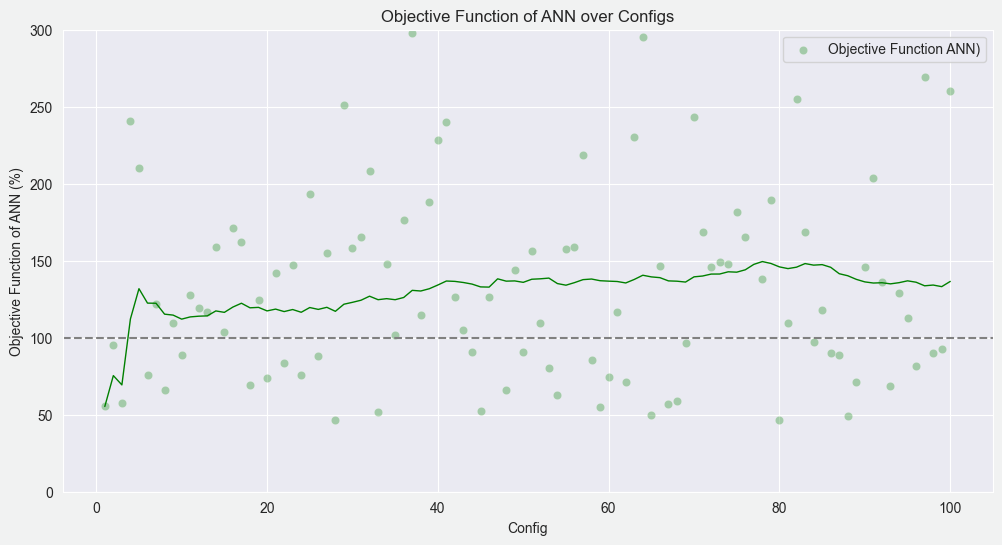

In [37]:
# Calculating objective fundtion as a percentage of brute force objective function
combined_data['obj_function_percentage_ann'] = (combined_data['obj_function_ann'] / combined_data['obj_function']) * 100

# Creating the line plot
plt.figure(figsize=(12, 6), facecolor='#f1f2f2')
sns.scatterplot(x='config_number', y='obj_function_percentage_ann', data=combined_data, label='Objective Function ANN)', color='green', alpha=0.3)

# Drawing a moving average line through the scatter points
window_size = 50
sns.lineplot(x='config_number', y=combined_data['obj_function_percentage_ann'].rolling(window=window_size, min_periods=1).mean(), data=combined_data, color='green', lw=1)

plt.axhline(100, color='gray', linestyle='--')

plt.ylim(0, 300)
title = 'Objective Function of ANN over Configs'
plt.title(title)
plt.xlabel('Config')
plt.ylabel('Objective Function of ANN (%)')
plt.ylim(ymin=0)
plt.legend()
plt.savefig(f'../images/{title.replace(" ", "_")}')
plt.show()

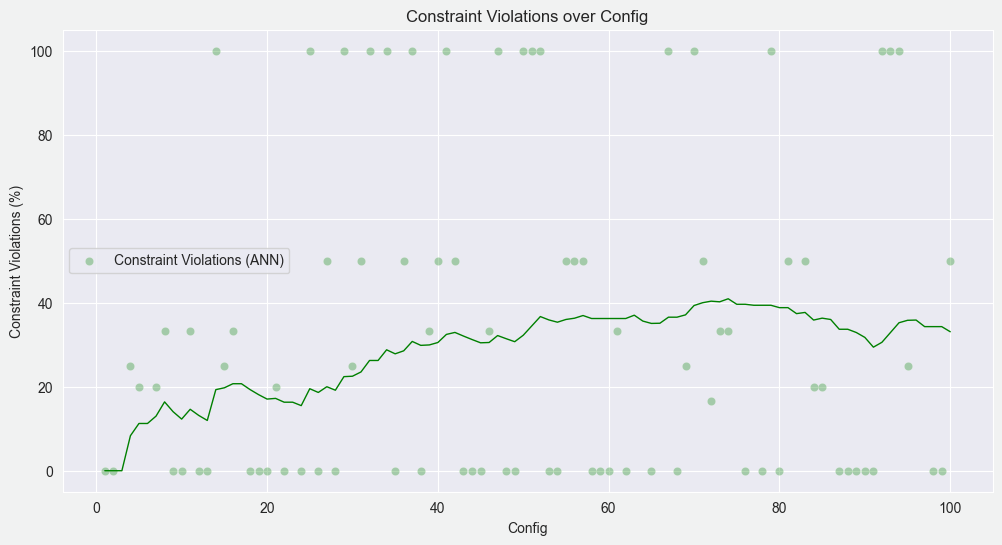

In [15]:
import ast

# Counting the number of False in is_perfect column for each config
combined_data['constraint_violations_ann'] = combined_data['is_perfect_ann'].apply(lambda x: ast.literal_eval(x).count(False))
combined_data['constraint_violations_nsga'] = combined_data['is_perfect'].apply(lambda x: ast.literal_eval(x).count(False))

# Calculating constraint_violations/services
combined_data['constraint_violations_ann'] = combined_data['constraint_violations_ann'] / combined_data['services']
combined_data['constraint_violations_nsga'] = combined_data['constraint_violations_nsga'] / combined_data['services']

combined_data['constraint_violations_ann_percent'] = (combined_data['constraint_violations_ann'] / combined_data['constraint_violations_nsga']) * 100

# Creating the line plot
plt.figure(figsize=(12, 6), facecolor='#f1f2f2')
sns.scatterplot(x='config_number', y='constraint_violations_ann_percent', data=combined_data, label='Constraint Violations (ANN)', color='green', alpha=0.3)

# Drawing a moving average line through the scatter points
window_size = 50
sns.lineplot(x='config_number', y=combined_data['constraint_violations_ann_percent'].rolling(window=window_size, min_periods=1).mean(), data=combined_data, color='green', lw=1)

title = 'Constraint Violations over Config'
plt.title(title)
plt.xlabel('Config')
plt.ylabel('Constraint Violations (%)')
plt.savefig(f'../images/{title.replace(" ", "_")}')
plt.show()

In [30]:
constraint_violation_data = combined_data['constraint_violations_ann_percent'].dropna()
constraint_violation_data[constraint_violation_data != float('inf')].mean()

32.655038759689916

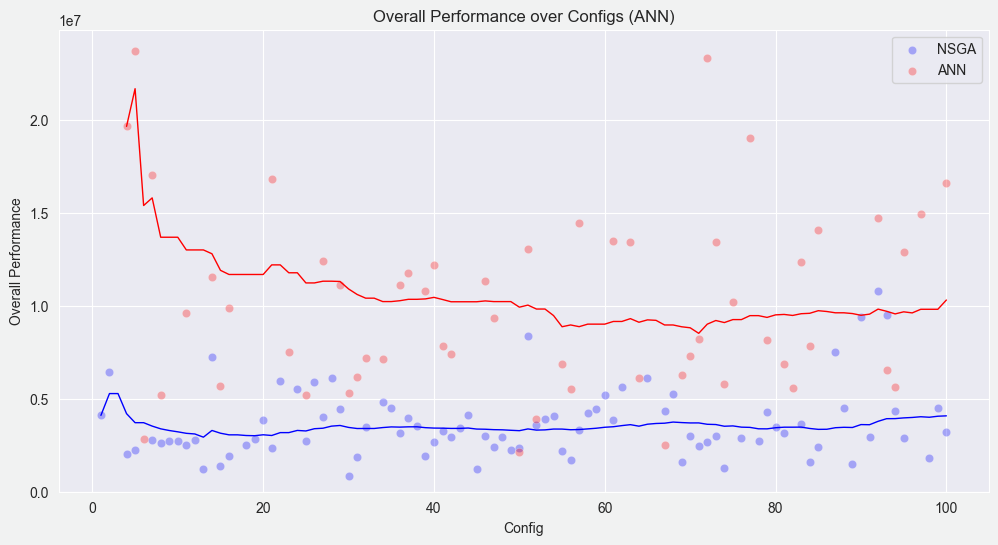

In [13]:
# Objective function * constraint_violations should give an idea of how much the objective function is affected by constraint violations
combined_data['obj_rate_nsga'] = 100 / combined_data['constraint_violations_nsga'] * combined_data['obj_function']
combined_data['obj_rate_ann'] = 100 / combined_data['constraint_violations_ann'] * combined_data['obj_function_ann']

# Creating the line plot
plt.figure(figsize=(12, 6), facecolor='#f1f2f2')
sns.scatterplot(x='config_number', y='obj_rate_nsga', data=combined_data, label='NSGA', color='blue', alpha=0.3)
sns.scatterplot(x='config_number', y='obj_rate_ann', data=combined_data, label='ANN', color='red', alpha=0.3)

# Drawing a moving average line through the scatter points
window_size = 50
sns.lineplot(x='config_number', y=combined_data['obj_rate_nsga'].rolling(window=window_size, min_periods=1).mean(), data=combined_data, color='blue', lw=1)
sns.lineplot(x='config_number', y=combined_data['obj_rate_ann'].rolling(window=window_size, min_periods=1).mean(), data=combined_data, color='red', lw=1)

title = 'Overall Performance over Configs (ANN)'
plt.title(title)
plt.xlabel('Config')
plt.ylabel('Overall Performance')
plt.ylim(ymin=0)
plt.savefig(f'../images/{title.replace(" ", "_")}')
plt.show()